In [1]:
import keras
import keras.backend as K
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Conv2DTranspose, Embedding, Multiply, Activation

from functools import partial

from collections import defaultdict

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import isolearn.io as isoio
import isolearn.keras as isol

import matplotlib.pyplot as plt

from sklearn import preprocessing
import pandas as pd

from sequence_logo_helper import dna_letter_at, plot_dna_logo

import tensorflow as tf

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [2]:

#optimus 5-prime functions 
def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].reshape(-1,1))
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2


#Train data
e_train = pd.read_csv("bottom5KIFuAUGTop5KIFuAUG.csv")
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))

seq_e_train = one_hot_encode(e_train,seq_len=50)
x_train = seq_e_train
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1], x_train.shape[2]))
y_train = np.array(e_train['scaled_rl'].values)
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("x_train.shape = " + str(x_train.shape))
print("y_train.shape = " + str(y_train.shape))


x_train.shape = (15008, 1, 50, 4)
y_train.shape = (15008, 1)


In [3]:
#Load Predictor
predictor_path = 'optimusRetrainedMain.hdf5'

predictor = load_model(predictor_path)

predictor.trainable = False
predictor.compile(optimizer=keras.optimizers.SGD(lr=0.1), loss='mean_squared_error')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [4]:
#Generate (original) predictions

pred_train = predictor.predict(x_train[:, 0, ...], batch_size=32)


In [5]:
###########################################
####################L2X####################
###########################################

from keras.callbacks import ModelCheckpoint
from keras.models import Model, Sequential 

import numpy as np
import tensorflow as tf

from keras.layers import MaxPooling2D, Flatten, Conv2D, Input, GlobalMaxPooling2D, Multiply, Lambda, Embedding, Dense, Dropout, Activation
from keras.datasets import imdb
from keras import backend as K  
from keras.engine.topology import Layer 

# Define various Keras layers.
class Concatenate1D(Layer):
    """
    Layer for concatenation. 

    """
    def __init__(self, **kwargs): 
        super(Concatenate1D, self).__init__(**kwargs)

    def call(self, inputs):
        input1, input2 = inputs  
        input1 = tf.expand_dims(input1, axis = -2) # [batchsize, 1, input1_dim] 
        dim1 = int(input2.get_shape()[1])
        input1 = tf.tile(input1, [1, dim1, 1])
        return tf.concat([input1, input2], axis = -1)

    def compute_output_shape(self, input_shapes):
        input_shape1, input_shape2 = input_shapes
        input_shape = list(input_shape2)
        input_shape[-1] = int(input_shape[-1]) + int(input_shape1[-1])
        input_shape[-2] = int(input_shape[-2])
        return tuple(input_shape)

class Concatenate2D(Layer):
    """
    Layer for concatenation. 

    """
    def __init__(self, **kwargs): 
        super(Concatenate2D, self).__init__(**kwargs)

    def call(self, inputs):
        input1, input2 = inputs  
        input1 = tf.expand_dims(tf.expand_dims(input1, axis = -2), axis = -2) # [batchsize, 1, 1, input1_dim] 
        dim1 = int(input2.get_shape()[1])
        dim2 = int(input2.get_shape()[2])
        input1 = tf.tile(input1, [1, dim1, dim2, 1])
        return tf.concat([input1, input2], axis = -1)

    def compute_output_shape(self, input_shapes):
        input_shape1, input_shape2 = input_shapes
        input_shape = list(input_shape2)
        input_shape[-1] = int(input_shape[-1]) + int(input_shape1[-1])
        input_shape[-2] = int(input_shape[-2])
        input_shape[-3] = int(input_shape[-3])
        return tuple(input_shape)

class Sample_Concrete(Layer):
    """
    Layer for sample Concrete / Gumbel-Softmax variables. 

    """
    def __init__(self, tau0, k, **kwargs): 
        self.tau0 = tau0
        self.k = k
        super(Sample_Concrete, self).__init__(**kwargs)

    def call(self, logits):   
        # logits: [batch_size, d, 1]
        logits_ = K.permute_dimensions(logits, (0,2,1))# [batch_size, 1, d]
        
        d = int(logits_.get_shape()[2])
        unif_shape = [batch_size,self.k,d]

        uniform = K.random_uniform_variable(shape=unif_shape,
            low = np.finfo(tf.float32.as_numpy_dtype).tiny,
            high = 1.0)
        gumbel = - K.log(-K.log(uniform))
        noisy_logits = (gumbel + logits_)/self.tau0
        samples = K.softmax(noisy_logits)
        samples = K.max(samples, axis = 1) 
        logits = tf.reshape(logits,[-1, d]) 
        threshold = tf.expand_dims(tf.nn.top_k(logits, self.k, sorted = True)[0][:,-1], -1)
        discrete_logits = tf.cast(tf.greater_equal(logits,threshold),tf.float32)

        output = K.in_train_phase(samples, discrete_logits) 
        return tf.expand_dims(output,-1)

    def compute_output_shape(self, input_shape):
        return input_shape

def construct_gumbel_selector(X_ph, n_filters=32, n_dense_units=32):
    """
    Build the L2X model for selection operator. 

    """
    first_layer = Conv2D(n_filters, (1, 7), padding='same', activation='relu', strides=1, name = 'conv1_gumbel')(X_ph)    

    # global info
    net_new = GlobalMaxPooling2D(name = 'new_global_max_pooling1d_1')(first_layer)
    global_info = Dense(n_dense_units, name = 'new_dense_1', activation='relu')(net_new) 

    # local info
    net = Conv2D(n_filters, (1, 7), padding='same', activation='relu', strides=1, name = 'conv2_gumbel')(first_layer) 
    local_info = Conv2D(n_filters, (1, 7), padding='same', activation='relu', strides=1, name = 'conv3_gumbel')(net)  
    combined = Concatenate2D()([global_info,local_info]) 
    net = Dropout(0.2, name = 'new_dropout_2')(combined)
    net = Conv2D(n_filters, (1, 1), padding='same', activation='relu', strides=1, name = 'conv_last_gumbel')(net)   

    logits_T = Conv2D(1, (1, 1), padding='same', activation=None, strides=1, name = 'conv4_gumbel')(net)  

    return logits_T


def L2X(x_train, y_train, pred_train, x_val, y_val, pred_val, k=10, batch_size=32, epochs=5, hidden_dims=250): 
    """
    Generate scores on features on validation by L2X.

    Train the L2X model with variational approaches 
    if train = True. 

    """
    
    Mean1D = Lambda(lambda x, k=k: K.sum(x, axis = 1) / float(k), output_shape=lambda x: [x[0],x[2]]) 

    Mean2D = Lambda(lambda x, k=k: K.sum(x, axis = (1, 2)) / float(k), output_shape=lambda x: [x[0],x[3]]) 
    
    print('Creating model...')

    # P(S|X)
    with tf.variable_scope('selection_model'):
        X_ph = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))

        logits_T = construct_gumbel_selector(X_ph)
        tau = 0.5
        
        #Extra code: Flatten 2D
        orig_logits_T = logits_T
        logits_T = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], x_train.shape[1] * x_train.shape[2], 1)))(logits_T)
        
        T = Sample_Concrete(tau, k)(logits_T)
        
        #Extra code: Inflate 2D
        T = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], x_train.shape[1], x_train.shape[2], 1)))(T)

    # q(X_S)
    with tf.variable_scope('prediction_model'):
        
        #Same architecture as original predictor
        
        net = Multiply()([X_ph, T])
        
        net = Conv2D(activation="relu", padding='same', filters=120, kernel_size=(1, 8))(net)
        net = Conv2D(activation="relu", padding='same', filters=120, kernel_size=(1, 8))(net)
        net = Conv2D(activation="relu", padding='same', filters=120, kernel_size=(1, 8))(net)
        net = Flatten()(net)
        net = Dense(hidden_dims, activation='relu')(net)
        net = Dropout(0.2)(net)
        preds = Dense(pred_train.shape[1], activation='linear', name = 'new_dense')(net)
        
        '''
        #Default approximator
        
        net = Mean2D(Multiply()([X_ph, T]))
        net = Dense(hidden_dims)(net)
        net = Dropout(0.2)(net)
        net = Activation('relu')(net) 
        preds = Dense(pred_train.shape[1], activation='softmax', name = 'new_dense')(net)
        '''


    model = Model(inputs=X_ph, outputs=preds)

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mean_squared_error']) 
    train_mse = np.mean((pred_train[:, 0] - y_train[:, 0])**2)
    val_mse = np.mean((pred_val[:, 0] - y_val[:, 0])**2)
    print('The train and validation mse of the original model is {} and {}'.format(train_mse, val_mse))

    #print(model.summary())
    '''
    checkpoint = ModelCheckpoint("saved_models/l2x.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
    model.fit(x_train, pred_train, 
        validation_data=(x_val, pred_val), 
        callbacks=[checkpoint],
        epochs=epochs, batch_size=batch_size
    )
    '''
    model.load_weights('saved_models/l2x.hdf5', by_name=True) 

    pred_model = Model([X_ph], [orig_logits_T, preds])
    pred_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    
    pred_model.load_weights('saved_models/l2x.hdf5', by_name=True) 

    scores, q = pred_model.predict(x_val, verbose=1, batch_size=batch_size)
    
    return scores, q


In [6]:
#Gradient saliency/backprop visualization

import matplotlib.collections as collections
import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def plot_importance_scores(importance_scores, ref_seq, figsize=(12, 2), score_clip=None, sequence_template='', plot_start=0, plot_end=96) :

    end_pos = ref_seq.find("#")
    
    fig = plt.figure(figsize=figsize)
    
    ax = plt.gca()
    
    if score_clip is not None :
        importance_scores = np.clip(np.copy(importance_scores), -score_clip, score_clip)
    
    max_score = np.max(np.sum(importance_scores[:, :], axis=0)) + 0.01

    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax)

    plt.sca(ax)
    plt.xlim((0, len(ref_seq)))
    plt.ylim((0, max_score))
    plt.axis('off')
    plt.yticks([0.0, max_score], [0.0, max_score], fontsize=16)
    
    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
    
    plt.tight_layout()
    
    plt.show()


(3, 1, 50, 4)
Creating model...
The train and validation mse of the original model is 0.08267584706296195 and 0.0
3/3 [==============================] - 0s 56ms/step
Test sequence 0:


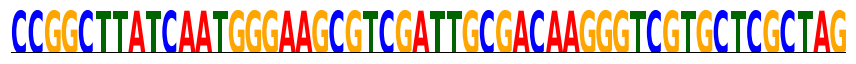

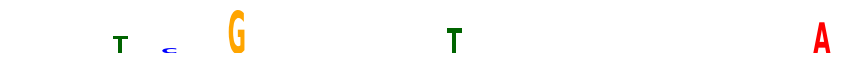

Test sequence 1:


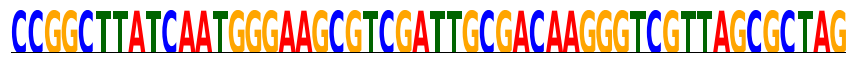

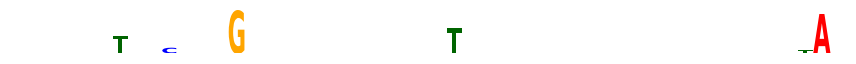

Test sequence 2:


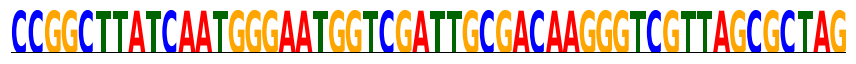

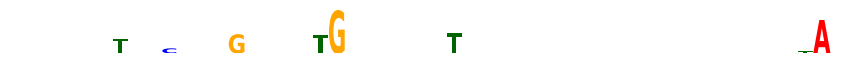

In [8]:
#Execute L2X benchmark on synthetic datasets

k = int(np.ceil(0.2 * 50))
batch_size = 32
hidden_dims = 40
epochs = 5

encoder = isol.OneHotEncoder(50)

score_clip = None

allFiles = ["optimus5_synthetic_random_insert_if_uorf_1_start_1_stop_variable_loc_512.csv",
            "optimus5_synthetic_random_insert_if_uorf_1_start_2_stop_variable_loc_512.csv",
            "optimus5_synthetic_random_insert_if_uorf_2_start_1_stop_variable_loc_512.csv",
            "optimus5_synthetic_random_insert_if_uorf_2_start_2_stop_variable_loc_512.csv",
            "optimus5_synthetic_examples_3.csv"]

for csv_to_open in allFiles :
    
    #Load dataset for benchmarking 
    dataset_name = csv_to_open.replace(".csv", "")
    benchmarkSet = pd.read_csv(csv_to_open)
    
    seq_e_test = one_hot_encode(benchmarkSet, seq_len=50)
    x_test = seq_e_test[:, None, ...]
    
    print(x_test.shape)
    
    pred_test = predictor.predict(x_test[:, 0, ...], batch_size=32)
    y_test = pred_test

    importance_scores_test, q_test = L2X(
        x_train,
        y_train,
        pred_train,
        x_test,
        y_test,
        pred_test,
        k=k,
        batch_size=batch_size,
        epochs=epochs,
        hidden_dims=hidden_dims
    )
    
    for plot_i in range(0, 3) :

        print("Test sequence " + str(plot_i) + ":")

        plot_dna_logo(x_test[plot_i, 0, :, :], sequence_template='N'*50, plot_sequence_template=True, figsize=(12, 1), plot_start=0, plot_end=50)
        plot_importance_scores(np.maximum(importance_scores_test[plot_i, 0, :, :].T, 0.), encoder.decode(x_test[plot_i, 0, :, :]), figsize=(12, 1), score_clip=score_clip, sequence_template='N'*50, plot_start=0, plot_end=50)

    #Save predicted importance scores

    model_name = "l2x_" + dataset_name

    np.save(model_name + "_importance_scores_test", importance_scores_test)
